# Python notebook to gather information about the dataset and its features

In [1]:
import numpy as np
import torch
import tkinter
import matplotlib.pyplot as plt
import matplotlib
import hdf5fileinout as hdf5io
import glob
import os
from pathlib import Path
from mpl_toolkits.mplot3d.art3d import Line3DCollection

from tqdm import tqdm
import torch_geometric as tg
from utils import compute_neighbors, compute_neighbor_kdtree

/volatile/home/gl271980/.virtualenvs/grand/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH_data = './data/GRAND_DATA/GP300Outbox/' #We need to exit code in this notebook
progenitor = 'Proton'
zenVal = '_' + str(74.8)  # 63.0, 74.8, 81.3, 85.0, 87.1
gui = 'TKAgg'

#matplotlib.use(gui)

In [3]:
list_f = glob.glob(PATH_data+'*'+progenitor+'*'+zenVal+'*')
# list_f = glob.glob(PATH_data+'*')
print('Number of files = %i' % (len(list_f)))

Number of files = 496


# One File

In [4]:
file = 0
def load_event(file_id):
    inputfilename = glob.glob(list_f[file] + '/*' + progenitor + '*' + zenVal + '*.hdf5')[0]
    run_info = hdf5io.GetRunInfo(inputfilename)
    event_name = hdf5io.GetEventName(run_info, 0)
    antenna_info = hdf5io.GetAntennaInfo(inputfilename, event_name)
    n_ant = hdf5io.GetNumberOfAntennas(antenna_info) #=len(antenna_info)
    energy = run_info['Energy'][0]
    zenith = 180. - hdf5io.GetEventZenith(run_info, 0)
    azimuth = hdf5io.GetEventAzimuth(run_info, 0)-180.

    lstPositions = []
    antenna_id = antenna_info["ID"].value
    antenna_pos = np.concatenate((antenna_info['X'].value[:, np.newaxis], antenna_info['Y'].value[:, np.newaxis], antenna_info['Z'].value[:, np.newaxis]), axis=-1)
    
    for ant in range(n_ant):
        efield_loc = hdf5io.GetAntennaEfield(inputfilename, event_name,
                                            str(antenna_id[ant], 'UTF-8'))
        if ant == 0:
            efields = np.zeros((n_ant, ) + efield_loc.shape)

        efields[ant] = efield_loc
    return antenna_id, antenna_pos, efields, (energy, zenith, azimuth)




In [5]:
file = 0

antenna_id, antenna_pos, efields, (energy, zenith, azimuth) = load_event(file)
edge_index, _ = compute_neighbors(antenna_pos)
edge_index = np.array(list(edge_index)) #Transform in array 
edge_index_mirrored = edge_index[:, [1, 0]]
edge_index = np.concatenate((edge_index, edge_index_mirrored), axis=0) #To have the edges in the 2 ways
edge_index = np.unique(edge_index, axis=0) #To remove the duplicates

In [6]:
#Peak to Peak energy
p2p_energy = np.max(efields[:, :, 1:], axis=1) - np.min(efields[:, :, 1:], axis=1)
print("X: max: ", np.max(p2p_energy[:, 0]), " min: ", np.min(p2p_energy[:, 0]))
print("Y: max: ", np.max(p2p_energy[:, 1]), " min: ", np.min(p2p_energy[:, 1]))
print("Z: max: ", np.max(p2p_energy[:, 2]), " min: ", np.min(p2p_energy[:, 2]))

np.argmax(p2p_energy[:, 1])

X: max:  823.5999755859375  min:  5.378999948501587
Y: max:  23612.899993896484  min:  84.43999862670898
Z: max:  2644.0  min:  23.309999465942383


35

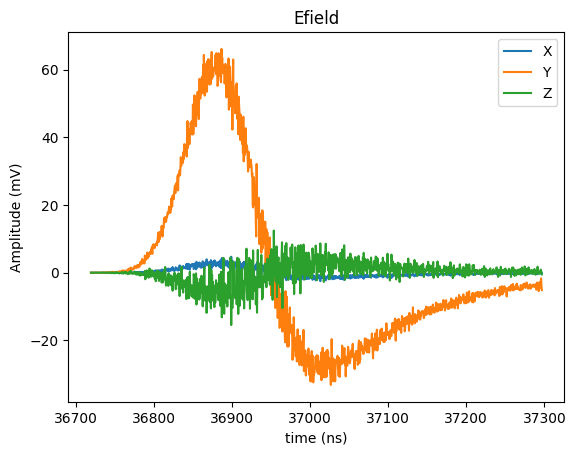

In [7]:
def plot_electromagnetic_field(efields, ant_id, title="Efield"):
    plt.plot(efields[ant_id, :, 0], efields[ant_id, :, 1], label="X")
    plt.plot(efields[ant_id, :, 0], efields[ant_id, :, 2], label="Y")
    plt.plot(efields[ant_id, :, 0], efields[ant_id, :, 3], label="Z")
    plt.legend()
    plt.title(title)
    plt.xlabel("time (ns)")
    plt.ylabel("Amplitude (mV)")
    plt.show()

ant = 50
plot_electromagnetic_field(efields, ant)

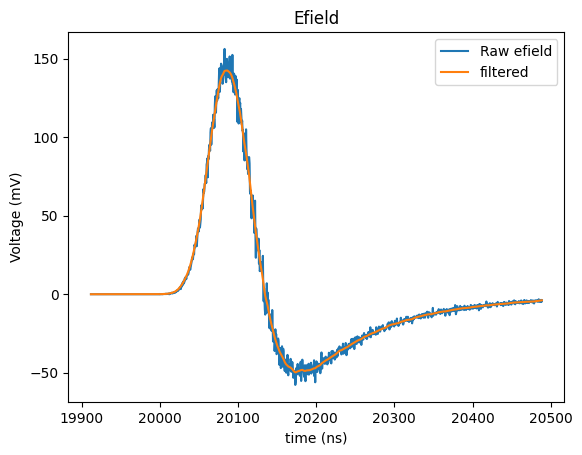

In [8]:
from scipy import signal
ant = 10

N  = 1    # Filter order
Wn = 0.05 # Cutoff frequency
B, A = signal.butter(N, Wn, output='ba')
filtered = signal.filtfilt(B,A, efields[ant, :, 2])

plt.plot(efields[ant, :, 0], efields[ant, :, 2], label="Raw efield")
plt.plot(efields[ant, :, 0], filtered, label="filtered")
plt.legend()
plt.title("Efield")
plt.xlabel("time (ns)")
plt.ylabel("Voltage (mV)")
plt.show()

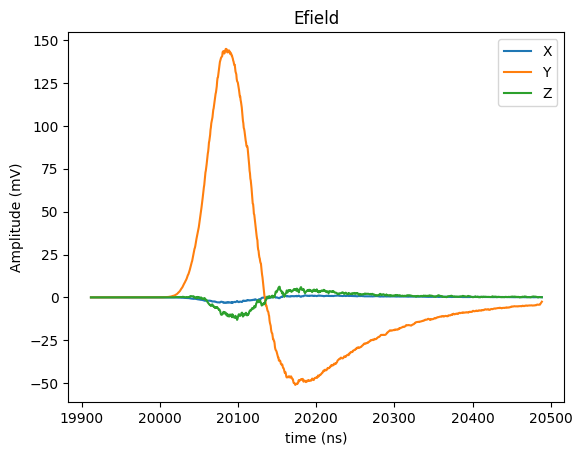

In [9]:
from scipy.ndimage import gaussian_filter1d

def smooth(efields, kernel_size=12):
    """Smooth efields for an event
    """
    filter = np.ones(kernel_size)
    
    #plot filter
    """
    plt.plot([(i-(len(np.pad(filter, kernel_size))/2))*0.5 for i in range(len(np.pad(filter, kernel_size)))], np.pad(filter, kernel_size))
    plt.title("filter")
    plt.ylabel("filter value")
    plt.xlabel("time (ps)")
    plt.show()
    """

    return np.apply_along_axis(lambda m: np.convolve(m, filter, mode="same")/np.sum(filter), axis=1, arr=efields)
    
def smooth_ant(efields, ant_id, kernel_size=5):
    """Smooth a efields signal for an antenna
    """
    efields[ant_id, :, 1] = np.convolve(efields[ant_id, :, 1], np.ones(kernel_size), mode="same")/np.sum(filter)
    efields[ant_id, :, 2] = np.convolve(efields[ant_id, :, 2], np.ones(kernel_size), mode="same")/np.sum(filter)
    efields[ant_id, :, 3] = np.convolve(efields[ant_id, :, 3], np.ones(kernel_size), mode="same")/np.sum(filter)
    
    return efields

efields[:, :, 1:] = smooth(efields[:, :, 1:])
plot_electromagnetic_field(efields, ant)

17348.844


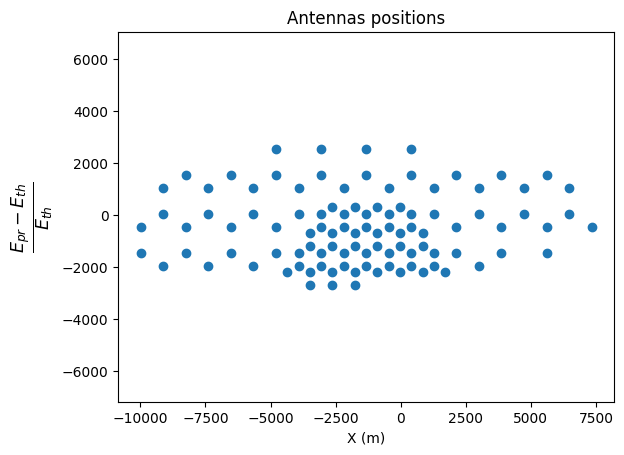

In [10]:
file = 179
antenna_id, antenna_pos, efields, (energy, zenith, azimuth) = load_event(file)


def computer_air_shower_diameter(efields, antenna_pos):
    max_dist = 0
    max_dist_ind = (0, 0)

    for ant in range(len(antenna_pos)):
        for ant2 in range(ant +1, len(antenna_pos)):
            if np.linalg.norm(antenna_pos[ant, :2] - antenna_pos[ant2, :2]) > max_dist:
                max_dist = np.linalg.norm(antenna_pos[ant, :2] - antenna_pos[ant2, :2])
                max_dist_ind = (ant, ant2)

    return max_dist, max_dist_ind

max_dist, max_dist_ind = computer_air_shower_diameter(efields, antenna_pos)

print(max_dist)
ax = plt.subplot()
plt.scatter(antenna_pos[:, 0], antenna_pos[:, 1])
plt.axis("equal")
plt.title("Antennas positions")
plt.xlabel("X (m)")
plt.ylabel(r"$\frac{E_{pr} - E_{th}}{E_{th}} $", fontsize=18)
plt.show()


# All files

In [11]:
antenna_pos_all_events = []
antenna_pos_id_dict = {}
antenna_id_all_events = []
efields_all_events = []
smooth_efields_all_events = []
energy_all_events = []
zenith_all_events = []
azimuth_all_events = []
edge_index_all_events = []
n_samples = 0
for file in tqdm(range(len(list_f))):
    antenna_id, antenna_pos, efields, (energy, zenith, azimuth) = load_event(file)
    
    n_samples += len(antenna_pos)
    
    edge_index, _ = compute_neighbors(antenna_pos)
    edge_index = np.array(list(edge_index)) #Transform in array 
    edge_index_mirrored = edge_index[:, [1, 0]]
    edge_index = np.concatenate((edge_index, edge_index_mirrored), axis=0) #To have the edges in the 2 ways
    edge_index = np.unique(edge_index, axis=0) #To remove the duplicates
    
    smooth_efields = np.copy(efields)
    smooth_efields[:, :, 1:] = smooth(efields[:, :, 1:])
    
    for incr in range(len(antenna_pos)):
        pos = tuple(antenna_pos[incr])
        if pos not in antenna_pos_id_dict:
            antenna_pos_id_dict[pos] = set()
        antenna_pos_id_dict[pos].add(antenna_id[incr])
    
    antenna_pos_all_events.append(antenna_pos)
    antenna_id_all_events.append(antenna_id)
    efields_all_events.append(efields)
    smooth_efields_all_events.append(smooth_efields)
    energy_all_events.append(energy)
    zenith_all_events.append(zenith)
    azimuth_all_events.append(azimuth)
    edge_index_all_events.append(edge_index)



100%|██████████| 496/496 [06:25<00:00,  1.29it/s]


# Antennas

In [12]:
#Test to check that the antenna has the same Z position 
for i in range(300):
    antenna_id = b'A' + str(i).encode('utf-8')
    lst_pos = []
    for event in range(len(antenna_id_all_events)):
        indicie = np.where(antenna_id_all_events[event] == antenna_id)[0]
        if len(indicie)>0:
            pos = antenna_pos_all_events[event][indicie[0]]
            lst_pos.append(pos[2])
    if len(np.unique(lst_pos))>1:
        print(np.unique(lst_pos))

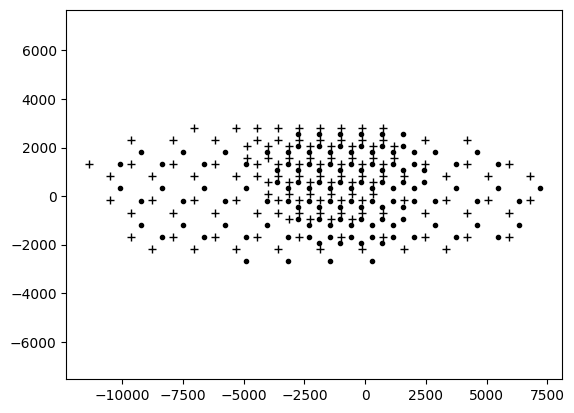

In [13]:
plt.plot(antenna_pos_all_events[10][:, 0], antenna_pos_all_events[10][:, 1], 'k.')
plt.plot(antenna_pos_all_events[0][:, 0], antenna_pos_all_events[0][:, 1], 'k+')
plt.axis('equal')
plt.show()

In [14]:
antenna_id_to_pos = {}
normalization_lst = []
for event in range(len(antenna_id_all_events)):
    normalization = None
    for incr in range(len(antenna_id_all_events[event])):
        antenna = antenna_id_all_events[event][incr]
        if antenna in antenna_id_to_pos:
            normalization = np.array(antenna_pos_all_events[event][incr]) - np.array(antenna_id_to_pos[antenna])
    if normalization is None:
        antenna_id_to_pos[antenna_id_all_events[event][0]] = antenna_pos_all_events[event][0]
        normalization = np.zeros((3,))
        
    for ant in range(len(antenna_id_all_events[event])):
        antenna = antenna_id_all_events[event][ant]
        if antenna in antenna_id_to_pos:
            #print(antenna_id_to_pos[antenna] - antenna_pos_all_events[event][ant] - normalization)
            if (antenna_id_to_pos[antenna] != antenna_pos_all_events[event][ant] - normalization).all():
                raise Exception("It can't be normalized")
        else:
            antenna_id_to_pos[antenna] = antenna_pos_all_events[event][ant] - normalization
            
    normalization_lst.append(normalization)
    #print(f"number of normalized antennas: {len(antenna_id_to_pos)}")

In [15]:
antenna_id_to_pos

{b'A45': array([-8777.68, -2181.37,  1114.62], dtype=float32),
 b'A46': array([-7045.68017578, -2181.37011719,  1099.22998047]),
 b'A47': array([-5313.68017578, -2181.37011719,  1084.01000977]),
 b'A48': array([-3581.67993164, -2181.37011719,  1080.35998535]),
 b'A49': array([-1849.68005371, -2181.37011719,  1063.64001465]),
 b'A50': array([ -117.68000031, -2181.37011719,  1053.75      ]),
 b'A51': array([ 1614.31994629, -2181.37011719,  1035.56994629]),
 b'A52': array([ 3346.32006836, -2181.37011719,  1021.13000488]),
 b'A54': array([-9643.6796875 , -1681.36999512,  1133.11999512]),
 b'A55': array([-7911.68017578, -1681.36999512,  1124.06994629]),
 b'A56': array([-6179.68017578, -1681.36999512,  1106.56005859]),
 b'A57': array([-4447.68017578, -1681.36999512,  1115.36999512]),
 b'A58': array([-2715.67993164, -1681.36999512,  1075.05004883]),
 b'A59': array([ -983.67999268, -1681.36999512,  1061.66003418]),
 b'A60': array([  748.32000732, -1681.36999512,  1047.48999023]),
 b'A61': arra

In [16]:
from utils import find_dense_antennas
_,dense_ants = find_dense_antennas(antenna_id_to_pos)

In [17]:
import random
antenna_id_to_pos_trunc = list(antenna_id_to_pos.items())
random.shuffle(antenna_id_to_pos_trunc)
antenna_id_to_pos_trunc = antenna_id_to_pos_trunc[:int(len(antenna_id_to_pos)* 0.8)]

dense_ants_trunc = list(dense_ants.items())
random.shuffle(dense_ants_trunc)
dense_ants_trunc = dense_ants_trunc[:int(len(dense_ants)* 0.8)]

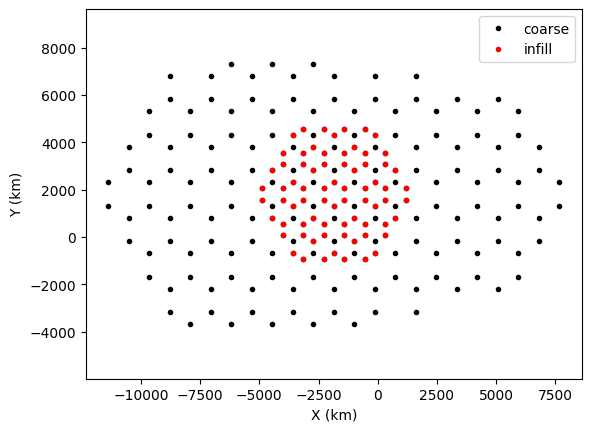

In [23]:
event = 75
plt.figure()
ax = plt.subplot()
plt.plot([values[0] for keys, values in antenna_id_to_pos.items()], [values[1] for keys, values in antenna_id_to_pos.items()], 'k.')
#plt.plot([values[0] for keys, values in antenna_id_to_pos_trunc], [values[1] for keys, values in antenna_id_to_pos_trunc], 'k.')
#plt.plot(antenna_pos_all_events[event][:, 0] - normalization_lst[event][0], antenna_pos_all_events[event][:, 1] - normalization_lst[event][1], 'r+')
plt.plot([values[0] for keys, values in dense_ants.items()], [values[1] for keys, values in dense_ants.items()], 'r.')
plt.legend(["coarse", "infill"])

plt.axis("equal")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.show()

In [19]:
arr = np.array([[0,1], [1,0], [1,1]])
np.lexsort((arr[:, 0], arr[:, 1]))

array([1, 0, 2])

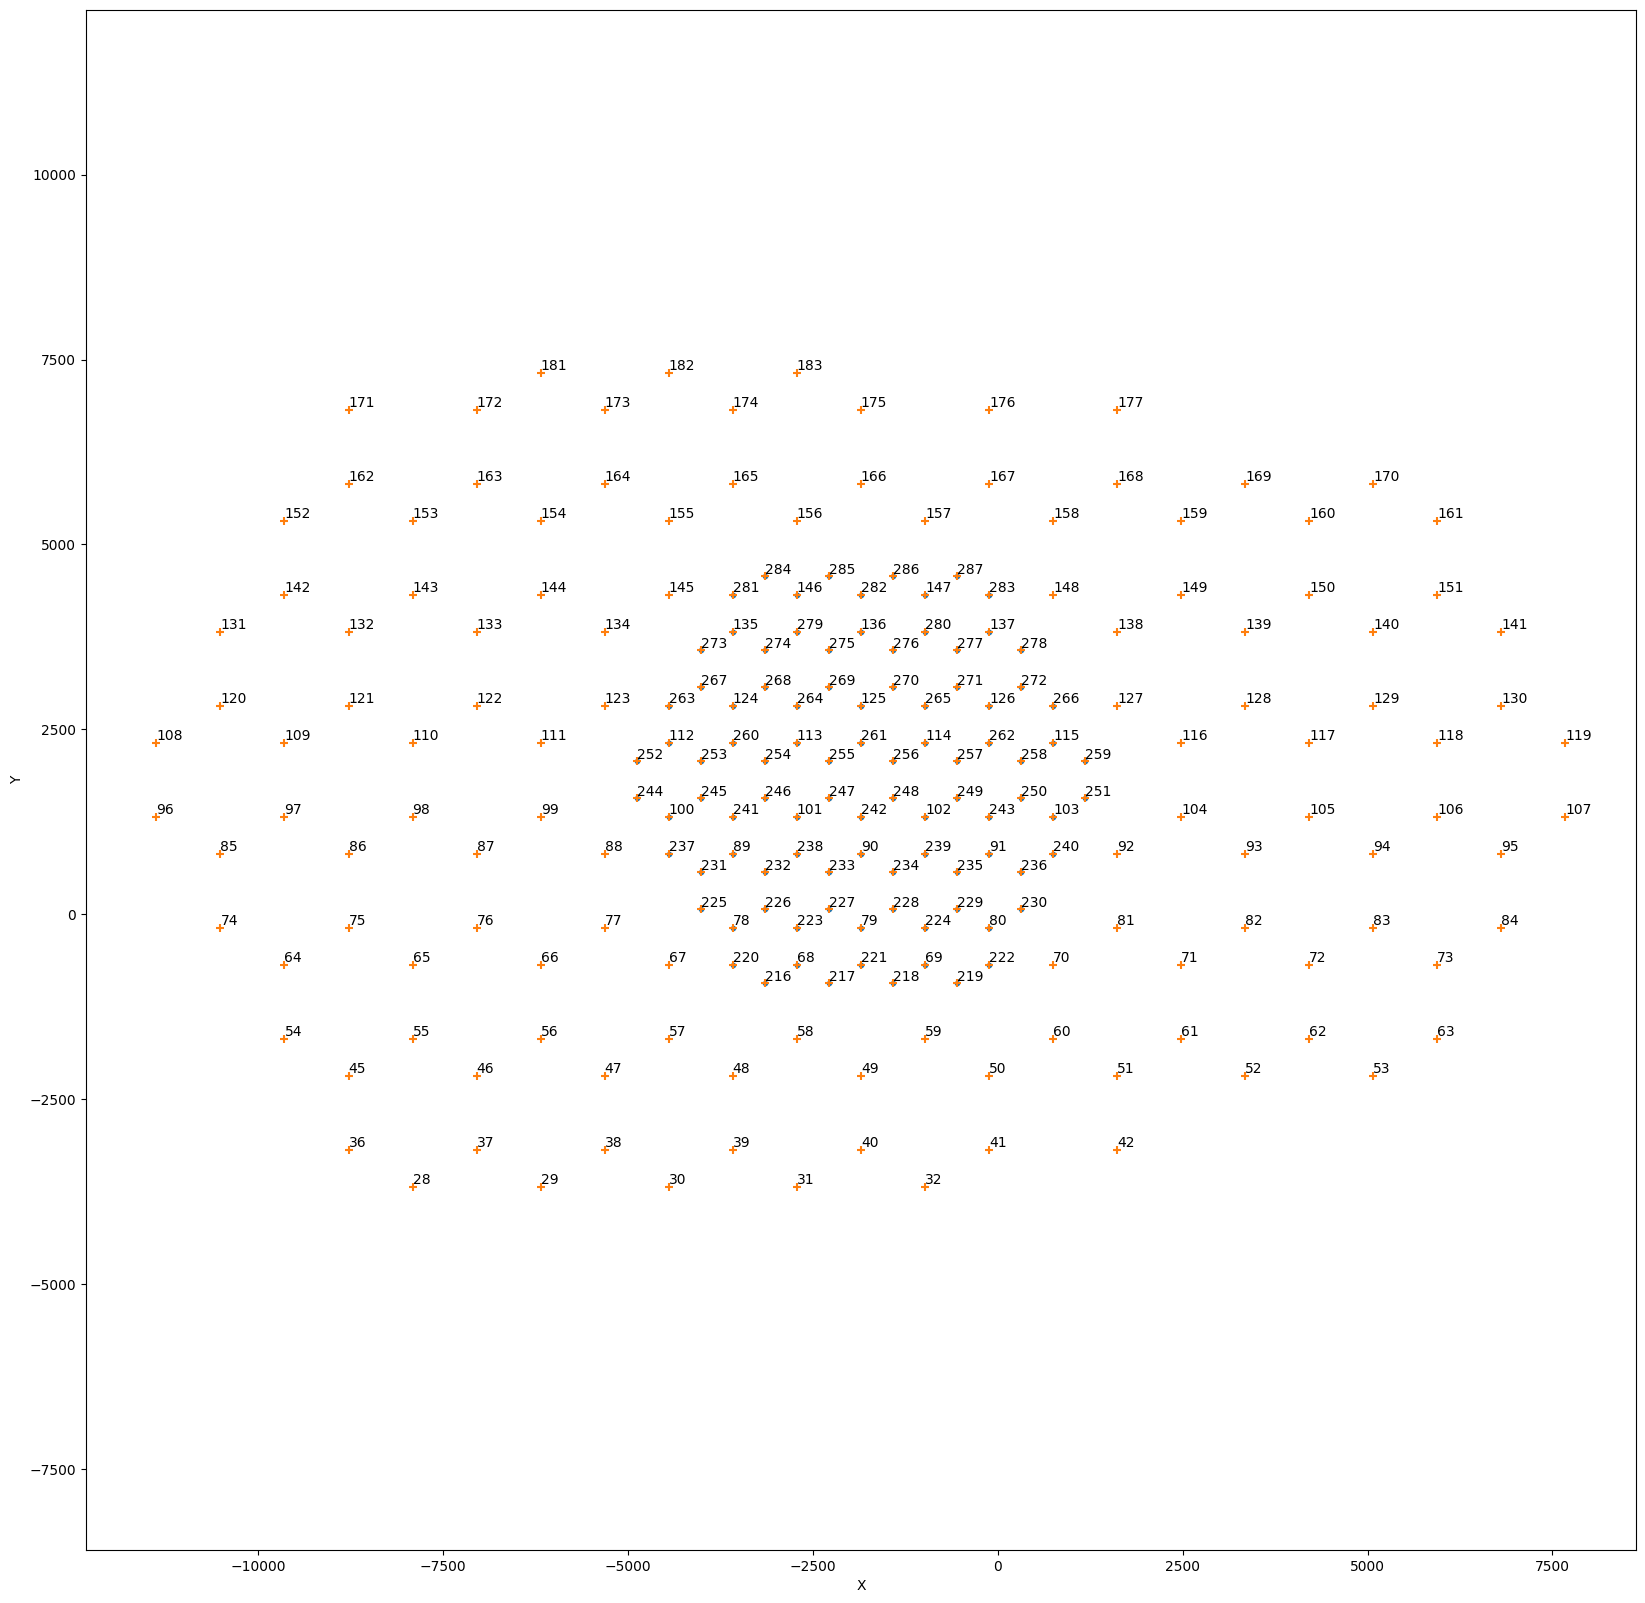

In [20]:
allowed_pos = np.array([-11376 + 870*i for i in range(30)])
all_values = np.array(list(antenna_id_to_pos.values()))
all_keys = np.array(list(antenna_id_to_pos.keys()))
sort_ind = np.lexsort((all_values[:, 0],all_values[:, 1]), axis=0)
antenna_id_to_pos_copy = {}
antenna_dense = {}
previous_val = None
previous_diff = None
for incr in range(len(all_keys[sort_ind])):
    value = all_values[sort_ind][incr]
    key = all_keys[sort_ind][incr]
    if np.any(np.abs(allowed_pos-value[0])<100):
        if previous_val is None or previous_val[1] != value[1]:
            previous_val = value
            previous_diff = None
            antenna_id_to_pos_copy[key] = value
            
        elif previous_diff is None:
            previous_diff = value[0] - previous_val[0]
            antenna_id_to_pos_copy[key] = value
            previous_val = value
        elif np.abs(previous_diff - (value[0] - previous_val[0])) < 10:
            antenna_id_to_pos_copy[key] = value
            previous_val = value
        else:
            antenna_dense[key] = value
    else:
        antenna_dense[key] = value

all_ants_pos = {}
for key, value in antenna_id_to_pos.items():
    in_droites = (-2 * value[0] + 4500) < value[1] or (2 * value[0] - 1000) > value[1] or (-2 * value[0] - 8500) > value[1] or (2*value[0] + 12000) < value[1]
    in_hexa = value[1] > 4800 or value[1] < -1200 or in_droites
    if in_hexa:
        continue
    all_ants_pos[key] = value

plt.figure(figsize=(20, 20))
plt.scatter([values[0] for keys, values in all_ants_pos.items()], [values[1] for keys, values in all_ants_pos.items()], marker='.')
plt.scatter([values[0] for keys, values in antenna_id_to_pos.items()], [values[1] for keys, values in antenna_id_to_pos.items()], marker='+')
for keys, values in antenna_id_to_pos.items():
    plt.annotate(str(keys)[3:-1], (values[0], values[1]), xytext=(0, 2), textcoords='offset points')
#plt.plot(antenna_pos_all_events[event][:, 0] - normalization_lst[event][0], antenna_pos_all_events[event][:, 1] - normalization_lst[event][1], 'r+')
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()

In [56]:
from utils import compute_neighbor_kdtree
event = 75
antenna_pos_corr = np.array([antenna_id_to_pos[id] for id in antenna_id_all_events[event]])
print([id for id in antenna_id_all_events[event]])
edge_index = compute_neighbor_kdtree(antenna_pos_corr, distance=1500)
print(len(edge_index), sorted(edge_index))

[b'A54', b'A55', b'A56', b'A57', b'A58', b'A59', b'A60', b'A64', b'A65', b'A66', b'A67', b'A68', b'A69', b'A70', b'A71', b'A72', b'A74', b'A75', b'A76', b'A77', b'A78', b'A79', b'A80', b'A81', b'A82', b'A83', b'A85', b'A86', b'A87', b'A88', b'A89', b'A90', b'A91', b'A92', b'A93', b'A94', b'A96', b'A97', b'A98', b'A99', b'A100', b'A101', b'A102', b'A103', b'A104', b'A105', b'A108', b'A109', b'A110', b'A111', b'A112', b'A113', b'A114', b'A115', b'A116', b'A120', b'A121', b'A122', b'A123', b'A124', b'A125', b'A126', b'A127', b'A216', b'A217', b'A218', b'A219', b'A220', b'A221', b'A222', b'A223', b'A224', b'A225', b'A226', b'A227', b'A228', b'A229', b'A230', b'A231', b'A232', b'A233', b'A234', b'A235', b'A236', b'A237', b'A238', b'A239', b'A240', b'A241', b'A242', b'A243', b'A244', b'A245', b'A246', b'A247', b'A248', b'A249', b'A250', b'A251', b'A252', b'A253', b'A254', b'A255', b'A256', b'A257', b'A258', b'A259', b'A260', b'A261', b'A262', b'A263', b'A264', b'A265', b'A266', b'A267', b'A2

In [20]:
antenna_dense.keys()

dict_keys([b'A216', b'A217', b'A218', b'A219', b'A220', b'A221', b'A222', b'A223', b'A224', b'A225', b'A226', b'A227', b'A228', b'A229', b'A230', b'A231', b'A232', b'A233', b'A234', b'A235', b'A236', b'A237', b'A238', b'A239', b'A240', b'A241', b'A242', b'A243', b'A244', b'A245', b'A246', b'A247', b'A248', b'A249', b'A250', b'A251', b'A252', b'A253', b'A254', b'A255', b'A256', b'A257', b'A258', b'A259', b'A260', b'A261', b'A262', b'A263', b'A264', b'A265', b'A266', b'A267', b'A268', b'A269', b'A270', b'A271', b'A272', b'A273', b'A274', b'A275', b'A276', b'A277', b'A278', b'A279', b'A280', b'A281', b'A282', b'A283', b'A284', b'A285', b'A286', b'A287'])

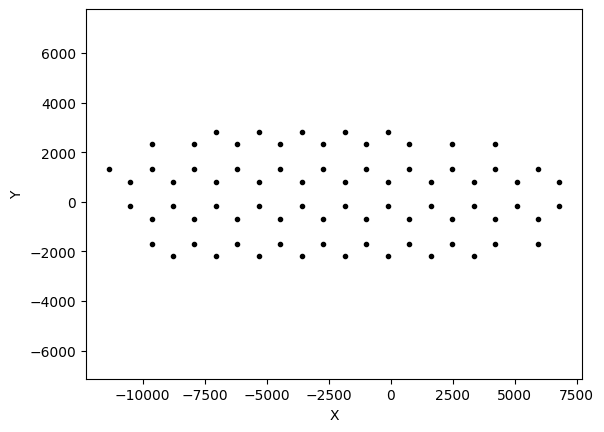

In [21]:
ants_id = antenna_id_all_events[0]
all_positions = []
for ant_id in ants_id:
    if ant_id in antenna_id_to_pos_copy:
        all_positions.append(antenna_id_to_pos_copy[ant_id])
        
all_positions = np.array(all_positions)
plt.plot(all_positions[:, 0], all_positions[:, 1], 'k.')
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.show()

# Peak to Peak

In [22]:
from utils import compute_peak2peak
print("nb samples: ", n_samples)

p2p_all, p2p_arr, p2p_ind = compute_peak2peak(efields_all_events)

print("X: max: ", np.max(p2p_arr[:, 0, 0]), " min: ", np.min(p2p_arr[:, 1, 0]))
print("Y: max: ", np.max(p2p_arr[:, 0, 1]), " min: ", np.min(p2p_arr[:, 1, 1]))
print("Z: max: ", np.max(p2p_arr[:, 0, 2]), " min: ", np.min(p2p_arr[:, 1, 2]))

print("X: max: event:", np.argmax(p2p_arr[:, 0, 0]), "ant: ", np.max(p2p_ind[np.argmax(p2p_arr[:, 0, 0]), 0, 0]), " min: event", np.argmin(p2p_arr[:, 1, 0]), "ant: ", np.min(p2p_ind[np.argmin(p2p_arr[:, 1, 0]), 1, 0]))
print("Y: max: event:", np.argmax(p2p_arr[:, 0, 1]), "ant: ", np.max(p2p_ind[np.argmax(p2p_arr[:, 0, 1]), 0, 1]), " min: event", np.argmin(p2p_arr[:, 1, 1]), "ant: ", np.min(p2p_ind[np.argmin(p2p_arr[:, 1, 1]), 1, 1]))
print("Z: max: event:", np.argmax(p2p_arr[:, 0, 2]), "ant: ", np.max(p2p_ind[np.argmax(p2p_arr[:, 0, 2]), 0, 2]), " min: event", np.argmin(p2p_arr[:, 1, 2]), "ant: ", np.min(p2p_ind[np.argmin(p2p_arr[:, 1, 2]), 1, 2]))


nb samples:  58822
X: max:  1315.5999755859375  min:  0.24309999495744705
Y: max:  27975.600006103516  min:  5.431999921798706
Z: max:  4576.0  min:  1.010200023651123
X: max: event: 283 ant:  44.0  min: event 270 ant:  9.0
Y: max: event: 269 ant:  97.0  min: event 482 ant:  53.0
Z: max: event: 283 ant:  44.0  min: event 225 ant:  23.0


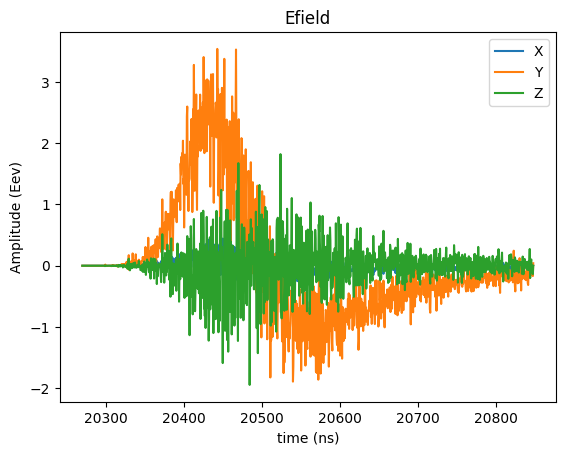

b'A171'


In [23]:
plot_electromagnetic_field(efields_all_events[482], 53)
print(antenna_id_all_events[482][53])
for i in range(len(antenna_id_all_events)):
    if b'A35' in antenna_id_all_events[i]:
        ind = np.where(antenna_id_all_events[i]==b'A35')[0]
        print(i, ind)
        plot_electromagnetic_field(efields_all_events[i], ind[0])

(487, 3)


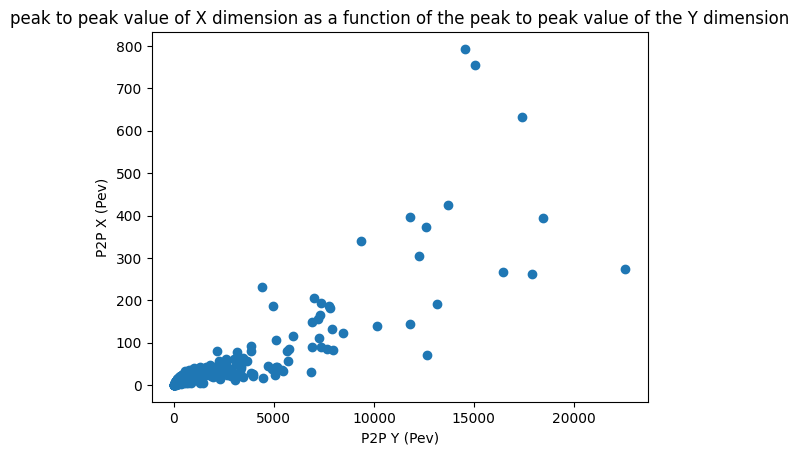

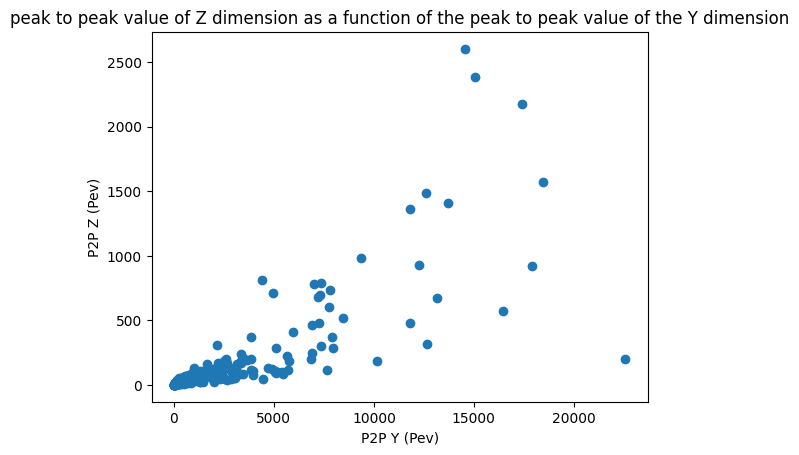

In [24]:
p2p_same_ant = []
ant_id = b'A254'
for event in range(len(p2p_all)):
    if ant_id in antenna_id_all_events[event]:
        ant_nb = np.where(antenna_id_all_events[event] == ant_id)[0][0]
        p2p_same_ant.append(p2p_all[event][ant_nb])

p2p_same_ant = np.array(p2p_same_ant)
print(p2p_same_ant.shape)
plt.scatter(p2p_same_ant[:, 1], p2p_same_ant[:, 0])
plt.title("peak to peak value of X dimension as a function of the peak to peak value of the Y dimension")
plt.xlabel("P2P Y (Pev)")
plt.ylabel("P2P X (Pev)")
plt.figure()
plt.title("peak to peak value of Z dimension as a function of the peak to peak value of the Y dimension")
plt.xlabel("P2P Y (Pev)")
plt.ylabel("P2P Z (Pev)")
plt.scatter(p2p_same_ant[:, 1], p2p_same_ant[:, 2])
plt.show()

# Antenna distribution

In [25]:
distrib_dict = {}
for i in range(len(antenna_id_all_events)):
    for ant in antenna_id_all_events[i]:
        if ant in distrib_dict:
            distrib_dict[ant] += 1
        else:
            distrib_dict[ant] = 1

print(f"number of antennas ID: {len(distrib_dict)}" )
print(sorted(distrib_dict.items(), key=lambda x:x[1]))

number of antennas ID: 220
[(b'A28', 1), (b'A32', 1), (b'A29', 2), (b'A30', 2), (b'A31', 2), (b'A183', 2), (b'A177', 3), (b'A181', 3), (b'A182', 3), (b'A42', 4), (b'A170', 7), (b'A176', 10), (b'A53', 11), (b'A171', 12), (b'A41', 13), (b'A161', 13), (b'A63', 14), (b'A175', 17), (b'A172', 20), (b'A36', 20), (b'A174', 21), (b'A173', 25), (b'A40', 27), (b'A37', 28), (b'A38', 32), (b'A39', 32), (b'A169', 34), (b'A119', 37), (b'A141', 38), (b'A52', 43), (b'A107', 44), (b'A160', 49), (b'A84', 53), (b'A62', 59), (b'A151', 59), (b'A73', 68), (b'A51', 72), (b'A168', 74), (b'A130', 76), (b'A95', 79), (b'A45', 89), (b'A50', 91), (b'A162', 96), (b'A167', 96), (b'A61', 97), (b'A159', 101), (b'A49', 104), (b'A46', 106), (b'A163', 112), (b'A166', 112), (b'A47', 113), (b'A48', 116), (b'A165', 120), (b'A164', 121), (b'A158', 133), (b'A60', 134), (b'A54', 137), (b'A72', 137), (b'A152', 138), (b'A106', 139), (b'A83', 140), (b'A118', 145), (b'A140', 145), (b'A59', 153), (b'A150', 153), (b'A157', 155), (b'A

# Length 

In [26]:
#Length of the events
min_length = np.inf
min_length_index = None

max_length = 0
max_length_index = None

for i in range(len(efields_all_events)):
    length = efields_all_events[i].shape[1] #0 is the number of antennas, 1 the length of the event and 2 the 4 coordinates 
    if length < min_length:
        min_length = length
        min_length_index = i
        
    if length > max_length:
        max_length = length
        max_length_index = i

print(f"max_length = {max_length}, min_length = {min_length}")
print(f"max_length_index = {max_length_index}, min_length_index = {min_length_index}")

max_length = 1582, min_length = 1120
max_length_index = 218, min_length_index = 96


# Time diff between peaks(with Smoothing)

In [27]:
# Time differences between the two spikes
time_diff_all, time_diff_peak, time_diff_peak_index = compute_time_diff_all_events(efields_all_events)

print("Y: max: ", np.max(time_diff_peak[:, 0]), " min: ", np.min(time_diff_peak[:, 1]))

print("Y_index: max: ", np.argmax(time_diff_peak[:, 0]), " ant: ", time_diff_peak_index[np.argmax(time_diff_peak[:, 0]),0 ], " min: ", np.argmin(time_diff_peak[:, 1]), " ant: ", time_diff_peak_index[np.argmin(time_diff_peak[:, 1]), 1])

print("Smooth Y: max: ", np.max(smooth_time_diff_peak[:, 0]), " min: ", np.min(smooth_time_diff_peak[:, 1]))

print("Smooth Y_index: max: ", np.argmax(smooth_time_diff_peak[:, 0]), " ant: ", smooth_time_diff_peak_index[np.argmax(smooth_time_diff_peak[:, 0]),0 ], " min: ", np.argmin(smooth_time_diff_peak[:, 1]), " ant: ", smooth_time_diff_peak_index[np.argmin(smooth_time_diff_peak[:, 1]), 1])

NameError: name 'compute_time_diff' is not defined

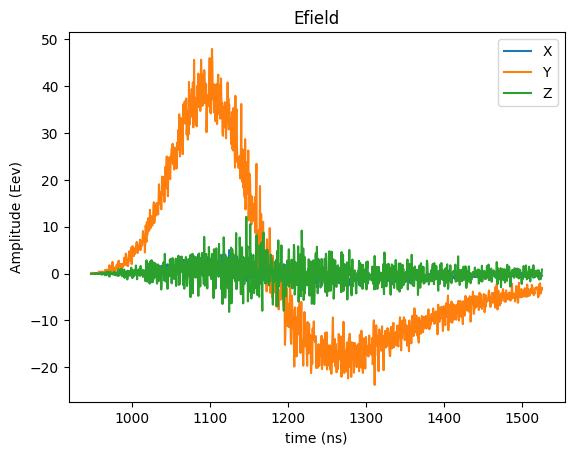

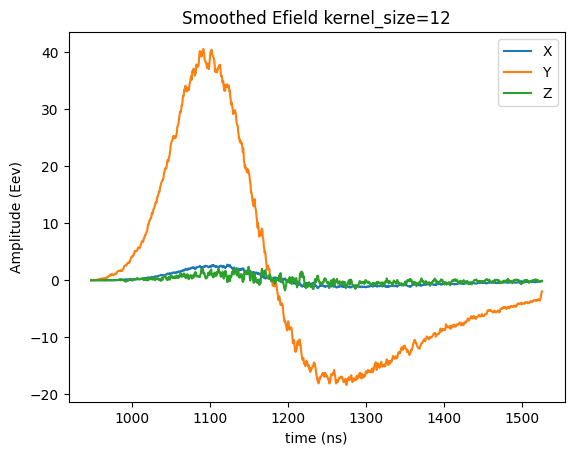

In [ ]:
plot_electromagnetic_field(efields_all_events[354], 58)
plot_electromagnetic_field(smooth_efields_all_events[354], 58, title="Smoothed Efield kernel_size=12")

# 10% of the peak

In [ ]:
    
indicie_max_arr, tau_arr = compute_time_response(smooth_efields_all_events)

flat_indicie_max_arr = np.array([item for sublist in indicie_max_arr for item in sublist])
flat_tau_arr = np.array([item for sublist in tau_arr for item in sublist])

antenna = b'A233'
flat_antenna_id = np.array([item for sublist in antenna_id_all_events for item in sublist])
flat_antenna_cond = np.where(flat_antenna_id==antenna)[0]

flat_time_diff_all = np.array([item for sublist in time_diff_all for item in sublist])
plt.scatter(flat_time_diff_all, flat_indicie_max_arr-flat_tau_arr, s=0.5)
#plt.scatter(flat_time_diff_all[flat_antenna_cond], flat_indicie_max_arr[flat_antenna_cond]-flat_tau_arr[flat_antenna_cond], s=0.5)
#plt.scatter(time_diff_all[482], np.array(indicie_max_arr[482])-np.array(tau_arr[482]))
plt.title("Response time as a function of the peak to peak time")
plt.xlabel("Time peak to peak")
plt.ylabel("Response time")
plt.show()

NameError: name 'compute_time_response' is not defined

# Energy

max:  3.9808000000000003 min:  0.11987
[114. 135. 131. 116.]


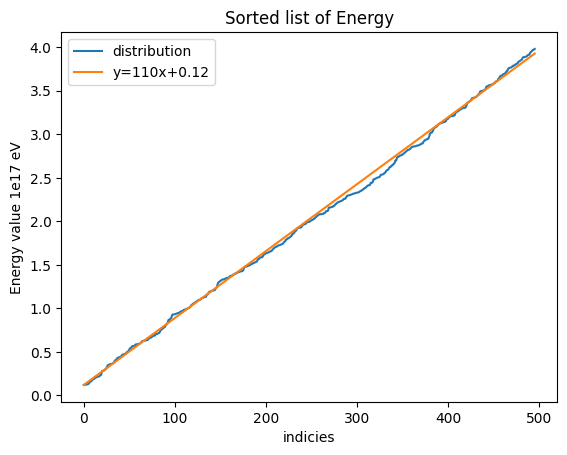

In [28]:
print("max: ", np.max(energy_all_events), "min: ", np.min(energy_all_events))
bins = np.zeros((4,))
bins[np.unique(np.floor(energy_all_events).astype(np.int8), return_counts=True)[0]] = np.unique(np.floor(energy_all_events).astype(np.int8), return_counts=True)[1]
print(bins)

plt.plot([i for i in range(len(energy_all_events))], np.sort(energy_all_events), label="distribution")
plt.plot([i for i in range(len(energy_all_events))], [0.12 + i/130 for i in range(len(energy_all_events))], label="y=110x+0.12")
plt.legend()
plt.title("Sorted list of Energy")
plt.xlabel("indicies")
plt.ylabel("Energy value 1e17 eV")
plt.show()

In [29]:
from sklearn.linear_model import LinearRegression
energy_all_events = np.array(energy_all_events)
len(p2p_all)
max_p2p = np.zeros(len(p2p_all))
for event in range(len(p2p_all)):
    max_p2p[event] = np.max(np.sqrt(p2p_all[event][:, 0]**2 + p2p_all[event][:, 1]**2 + p2p_all[event][:, 2]**2))

[[0.00015443]]


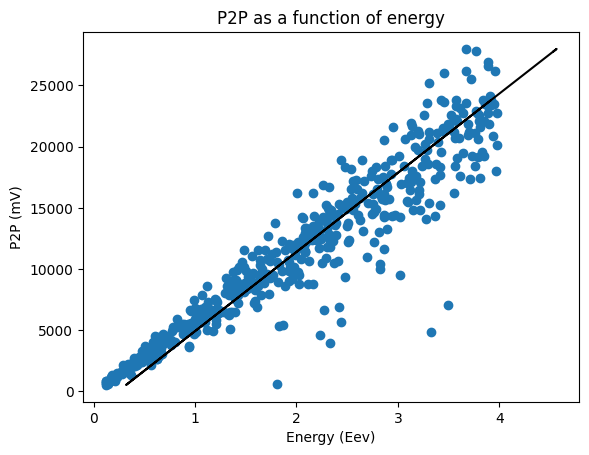

In [30]:
   
reg = LinearRegression().fit(np.expand_dims(max_p2p, axis=-1), np.expand_dims(energy_all_events, axis=-1))
print(reg.coef_)
preds = reg.predict(np.expand_dims(max_p2p, axis=-1))[:, 0]
plt.scatter(energy_all_events, max_p2p)
plt.plot(preds, max_p2p, "k")
plt.title("P2P as a function of energy")
plt.xlabel("Energy (Eev)")
plt.ylabel("P2P (mV)")
plt.show()


In [32]:
# ## We do the mean of the models ## #
bins = [0.11 + (i + 1) * (3.99-0.11) / 10 for i in range(10)] 
ind_bins = np.digitize(energy_all_events, bins)
pred_train_mean, pred_train_std, true_train_mean = [], [], []
for bin in range(len(bins)):
    indicies = np.where(ind_bins == bin)[0] ###TODO adapt to the test after train
    pred_train_mean.append(np.mean(preds[indicies] - energy_all_events[indicies]))
    true_train_mean.append(np.mean(energy_all_events[indicies]))

pred_train_mean, true_train_mean = np.array(pred_train_mean), np.array(true_train_mean)

plt.clf()
plt.scatter(true_train_mean, pred_train_mean, label="Train")
plt.plot(true_train_mean, [0 for _ in range(len(true_train_mean))], "k")
plt.title("Results")
plt.xlabel("ground truth energy (EeV)")
plt.ylabel("$E_{pr} - E_{th} (EeV)$")
plt.xlim(0, 4.1)
plt.legend()

plt.figure()
plt.scatter(true_train_mean, pred_train_mean/true_train_mean, label="Train")
plt.plot(true_train_mean, [0 for _ in range(len(true_train_mean))], "k")
plt.title("Results")
plt.xlabel("ground truth energy (EeV)")
plt.ylabel(r"$\frac{E_{pr} - E_{th}}{E_{th}} $")
plt.xlim(0, 4.1)
plt.legend()

plt.show()

NameError: name 'preds' is not defined

In [43]:
#Test with XGBoost
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

# Splitting
train_X, test_X, train_y, test_y = train_test_split(np.expand_dims(max_p2p, axis=-1), np.expand_dims(energy_all_events, axis=-1),
                      test_size = 0.2)
 
# Instantiation
xgb_r = xg.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
 
# Fitting the model
xgb_r.fit(train_X, train_y)
 
# Predict the model
pred = xgb_r.predict(test_X)
 
# RMSE Computation
rmse = MSE(test_y, pred)
print("MSE : % f" %(rmse))

MSE :  0.218263


# Azimuth and Zenith

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

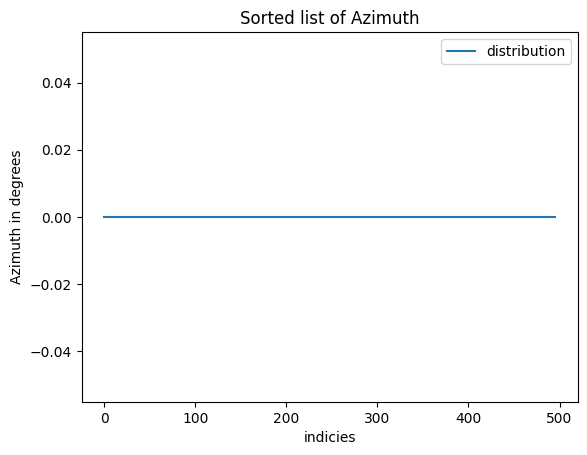

In [ ]:
print(azimuth_all_events)
print(np.sort(azimuth_all_events))
plt.plot([i for i in range(len(azimuth_all_events))], np.sort(azimuth_all_events), label="distribution")
#plt.plot([i for i in range(len(azimuth_all_events))], [0.12 + i/130 for i in range(len(azimuth_all_events))], label="y=110x+0.12")
plt.legend()
plt.title("Sorted list of Azimuth")
plt.xlabel("indicies")
plt.ylabel("Azimuth in degrees")
plt.show()

# Corelation

## Amplitude vs Time diff

In [ ]:
from copy import deepcopy

smooth_efields_all_events = deepcopy(efields_all_events)
for event in range(len(efields_all_events)):
    smooth_efields_all_events[event][:, :, 1:] = gaussian_filter1d(efields_all_events[event][:, :, 1:], sigma=5, axis=1)

p2p_all, _, _ = compute_peak2peak(smooth_efields_all_events)
time_diff_all, _, _, _, _ = compute_time_diff_all_events(smooth_efields_all_events)


In [ ]:
flat_p2p = np.array([item for sublist in p2p_all for item in sublist[:, 1]])
flat_time_diff = np.array([item for sublist in time_diff_all for item in sublist])

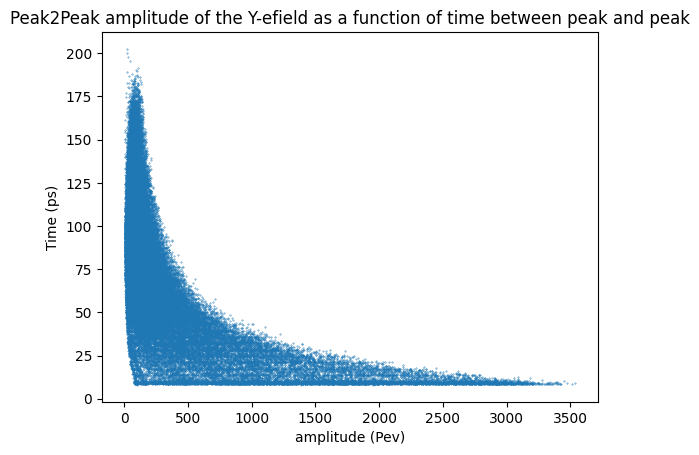

In [ ]:
plt.scatter(flat_p2p, flat_time_diff, s=0.1)
plt.title("Peak2Peak amplitude of the Y-efield as a function of time between peak and peak")
plt.xlabel("amplitude (Pev)")
plt.ylabel("Time (ps)")
plt.show()

## Diameter of the circle as a function of energy

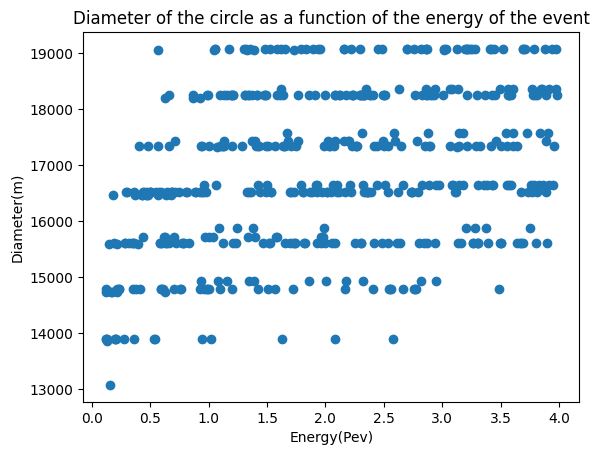

In [99]:
diam_all_events = []
for event in range(len(efields_all_events)):
    diam_all_events.append(computer_air_shower_diameter(efields_all_events[event], antenna_pos_all_events[event] - normalization_lst[event])[0])

plt.scatter(energy_all_events, diam_all_events)
plt.title("Diameter of the circle as a function of the energy of the event")
plt.xlabel("Energy(Pev)")
plt.ylabel("Diameter(m)")
plt.show()